# Sport Vouchers Program Analysis

The goal of this Portfolio task is to explore data from the Federal Government Sport Vouchers program - this is a
program that provides up to two $100 vouchers for kids to participate in organised sport. Here's the [NSW Active Kids page](https://www.service.nsw.gov.au/transaction/apply-active-kids-voucher), there are similar schemes in other states - this data is from South Australia.

This is an exercise in exploring data and communicating the insights you can gain from it.  The source data comes
from the `data.gov.au` website and provides details of all Sport Vouchers that have been redeemed since February  in SA 2015 as part of the Sport Voucher program:  [Sports Vouchers Data](https://data.gov.au/dataset/ds-sa-14daba50-04ff-46c6-8468-9fa593b9f100/details).  This download is provided for you as `sportsvouchersclaimed.csv`.

To augment this data you can also make use of [ABS SEIFA data by LGA](http://stat.data.abs.gov.au/Index.aspx?DataSetCode=ABS_SEIFA_LGA#) which shows a few measures of Socioeconomic Advantage and Disadvantage for every Local Government Area. This data is provided for you as `ABS_SEIFA_LGA.csv`. This could enable you to answer questions about whether the voucher program is used equally by parents in low, middle and high socioeconomic areas.   You might be interested in this if you were concerned that this kind of program might just benifit parents who are already advantaged (they might already be paying for sport so this program wouldn't be helping much).

Questions:
* Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out? 
* Are some sports more popular in different parts of the state?
* Are any electorates over/under represented in their use of vouchers?
* Is there a relationship between any of the SEIFA measures and voucher use in an LGA?

A challenge in this task is to display a useful summary of the data given that there are a large number of LGAs and sports involved.  Try to avoid long lists and large tables. Think about what plots and tables communicate the main points of your findings. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# read the sports vouchers data
sa_vouchers = pd.read_csv("sportsvouchersclaimed.csv")
sa_vouchers.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015


The SEIFA data includes row for each Local Government Area (LGA) but the names of the LGAs have a letter or letters in brackets after the name.  To allow us to match this up with the voucher data we remove this and convert to uppercase. 

For each LGA the data includes a number of measures all of which could be useful in your exploration.  

In [3]:
# read the SEIFA data, create an LGA column by removing the letters in brackets and converting to uppercase
seifa = pd.read_csv('ABS_SEIFA_LGA.csv')
seifa = seifa[seifa.LGA_2011.astype(str).str[0]=='4']
lga = seifa["Local Government Areas - 2011"].str.replace(' \([ACSRCDMT]+\)', '').str.upper()
seifa['LGA'] = lga
seifa.head()

<ipython-input-3-1896cf568937>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  lga = seifa["Local Government Areas - 2011"].str.replace(' \([ACSRCDMT]+\)', '').str.upper()


,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA
1228,40070,Adelaide (C),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,1036,ADELAIDE
1229,40070,Adelaide (C),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,909,ADELAIDE
1230,40070,Adelaide (C),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,1141,ADELAIDE
1231,40070,Adelaide (C),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,19606,ADELAIDE
1232,40120,Adelaide Hills (DC),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,1077,ADELAIDE HILLS


Since there are many rows per LGA we need to use `pivot_table` to create a new data frame with one row per LGA. Here
is an example of doing this to create a table with the different SCORE measures and the population (URP) field. 

In [4]:
LGA_scores = seifa[seifa.MEASURE == 'SCORE'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores.head()
LGA_pop = seifa[seifa.MEASURE == 'URP'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores['Population'] = LGA_pop.IEO
LGA_scores.head()

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population
LGA,,,,,
ADELAIDE,874,874,1036,1013,19606
ADELAIDE HILLS,1083,1083,1077,1081,38601
ALEXANDRINA,1000,1000,969,987,23693
ANANGU PITJANTJATJARA,623,623,672,593,2433
BAROSSA,1028,1028,997,1017,22174


This data frame can then be joined with the vouchers data fram to create one master data frame containing both the voucher data and the SEIFA measures.

In [5]:
sa_vouchers_scores = sa_vouchers.join(LGA_scores, on='Participant_LGA')
sa_vouchers_scores.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996.0,996.0,975.0,993.0,159517.0
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996.0,996.0,975.0,993.0,159517.0
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996.0,996.0,975.0,993.0,159517.0
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996.0,996.0,975.0,993.0,159517.0
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996.0,996.0,975.0,993.0,159517.0


In [6]:
sa_vouchers_scores.groupby(['Participant_LGA']).mean()

,Participant_ID,Voucher_Value,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
Participant_LGA,,,,,,,,
ADELAIDE,1.029358e+06,50.000000,2015.894040,874.0,874.0,1036.0,1013.0,19606.0
ADELAIDE HILLS,1.051112e+06,49.951640,2015.793314,1083.0,1083.0,1077.0,1081.0,38601.0
ADELAIDE PLAINS,1.073646e+06,49.878754,2015.975528,NaN,NaN,NaN,NaN,NaN
ALEXANDRINA,1.071038e+06,49.946291,2015.883854,1000.0,1000.0,969.0,987.0,23693.0
BAROSSA,1.077192e+06,49.872999,2015.929715,1028.0,1028.0,997.0,1017.0,22174.0
...,...,...,...,...,...,...,...,...
WEST TORRENS,1.064404e+06,49.971871,2015.897328,949.0,949.0,989.0,998.0,54932.0
WHYALLA,1.120806e+06,48.370981,2015.930064,905.0,905.0,897.0,905.0,22070.0
WUDINNA,1.114339e+06,38.164794,2015.955056,1008.0,1008.0,999.0,1023.0,1256.0


Distribution of Vouchers in LGA's in SA:

Top 5:
ONKAPARINGA       12782
SALISBURY          8169
TEA TREE GULLY     7219
PLAYFORD           6940
CHARLES STURT      6897
Name: Participant_LGA, dtype: int64

Bottom 5:
FRANKLIN HARBOUR     155
ORROROO/CARRIETON    137
FLINDERS RANGES      102
PETERBOROUGH          45
COOBER PEDY           39
Name: Participant_LGA, dtype: int64


Percentage of Vouchers distributed in LGA's in SA:


<AxesSubplot:ylabel='Participant_LGA'>

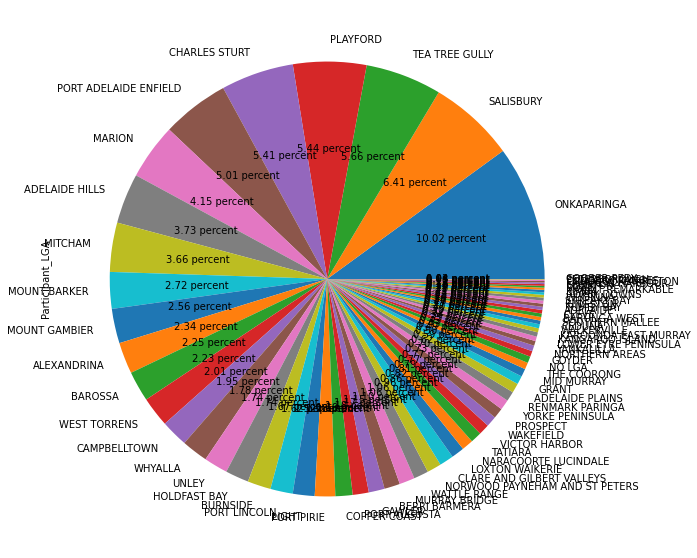

In [7]:
#Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out?
print("Distribution of Vouchers in LGA's in SA:")
print("\nTop 5:")
print(sa_vouchers_scores.Participant_LGA.value_counts().head())
print("\nBottom 5:")
print(sa_vouchers_scores.Participant_LGA.value_counts().tail())

print("\n\nPercentage of Vouchers distributed in LGA's in SA:")
plt.figure(figsize=(20,10))
sa_vouchers_scores.Participant_LGA.value_counts().plot.pie(autopct="%.2f percent")

Distribution of Vouchers redeemed for each sport:

Top 5:
Australian Rules     47224
Netball              24017
Football (Soccer)    15775
Gymnastics            9823
Basketball            6016
Name: Voucher_Sport, dtype: int64

Bottom 5:
Weightlifting       4
Paralympics         3
Kung Fu (Wu Shu)    2
Dancesport          2
Bowls               2
Name: Voucher_Sport, dtype: int64


Percentage of Vouchers redeemed for each sport:


<AxesSubplot:ylabel='Voucher_Sport'>

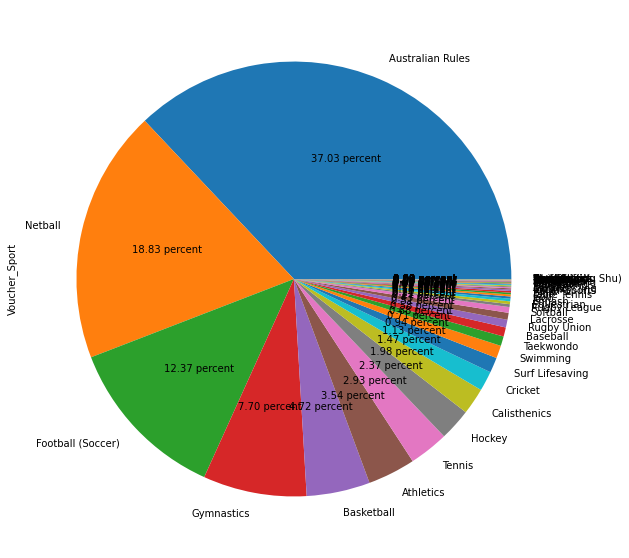

In [8]:
print("Distribution of Vouchers redeemed for each sport:")
print("\nTop 5:")
print(sa_vouchers_scores.Voucher_Sport.value_counts().head())
print("\nBottom 5:")
print(sa_vouchers_scores.Voucher_Sport.value_counts().tail())

print("\n\nPercentage of Vouchers redeemed for each sport:")
plt.figure(figsize=(20,10))
sa_vouchers_scores.Voucher_Sport.value_counts().plot.pie(autopct="%.2f percent")

In [9]:
print("Number of Vouchers redeemed in each year:")
print(sa_vouchers_scores.Voucher_Claim_Year.value_counts())

Number of Vouchers redeemed in each year:
2016    51959
2015    43197
2017    32370
Name: Voucher_Claim_Year, dtype: int64


In [10]:
print("From the summary above, the regions (LGA's) with the highest uses of sport vouchers are ONKAPARINGA, followed by\n"
"SALISBURY, TEA TREE GULLY, PLAYFORD and CHARLES STURT. The most vouchers used for a sport are Australian Rules "
"followed by Netball, Football, Gymnastics and Basketball\n")

print("The sports with the lowest uses of sport vouchers are FRANKLIN HARBOUR then ORROROO/CARRIETON, FLINDERS RANGES \n"
"PETERBOROUGH and COOBER PEDY. The least vouchers used for a sport are Shooting, Paralymics, Bowls, Dancesport and Kung Fu")

From the summary above, the regions (LGA's) with the highest uses of sport vouchers are ONKAPARINGA, followed by
SALISBURY, TEA TREE GULLY, PLAYFORD and CHARLES STURT. The most vouchers used for a sport are Australian Rules followed by Netball, Football, Gymnastics and Basketball

The sports with the lowest uses of sport vouchers are FRANKLIN HARBOUR then ORROROO/CARRIETON, FLINDERS RANGES 
PETERBOROUGH and COOBER PEDY. The least vouchers used for a sport are Shooting, Paralymics, Bowls, Dancesport and Kung Fu


In [43]:
#Are some sports more popular in different parts of the state? (Analysed top 5/bottom 5 CHANGE BACK TO ALL NO HARDCODING IF TIME)

def Lga_Sport(LGA):
    print("\nDistribution of Vouchers redeemed for each sport in {}:".format(LGA))
    print("Top 5:")
    print(sa_vouchers_scores[sa_vouchers_scores.Participant_LGA == LGA].Voucher_Sport.value_counts().head())

Lga_Sport("ONKAPARINGA")
Lga_Sport("SALISBURY")
Lga_Sport("TEA TREE GULLY")
Lga_Sport("PLAYFORD")
Lga_Sport("CHARLES STURT")
Lga_Sport("FRANKLIN HARBOUR")
Lga_Sport("ORROROO/CARRIETON")
Lga_Sport("FLINDERS RANGES")
Lga_Sport("PETERBOROUGH")
Lga_Sport("COOBER PEDY") 


Distribution of Vouchers redeemed for each sport in ONKAPARINGA:
Top 5:
Australian Rules     5258
Netball              2242
Gymnastics           1211
Football (Soccer)    1204
Athletics             541
Name: Voucher_Sport, dtype: int64

Distribution of Vouchers redeemed for each sport in SALISBURY:
Top 5:
Australian Rules     2856
Football (Soccer)    2069
Gymnastics            763
Netball               566
Basketball            362
Name: Voucher_Sport, dtype: int64

Distribution of Vouchers redeemed for each sport in TEA TREE GULLY:
Top 5:
Australian Rules     2131
Football (Soccer)    1356
Gymnastics           1114
Netball              1068
Basketball            284
Name: Voucher_Sport, dtype: int64

Distribution of Vouchers redeemed for each sport in PLAYFORD:
Top 5:
Australian Rules     2580
Football (Soccer)    1880
Netball               904
Gymnastics            451
Calisthenics          216
Name: Voucher_Sport, dtype: int64

Distribution of Vouchers redeemed for each sport in C

In [12]:
#Are any electorates over/under represented in their use of vouchers?

In [13]:
#Is there a relationship between any of the SEIFA measures and voucher use in an LGA?

## Challenge - Queensland

_Note: this is an extra task that you might take on to get a better grade for your portfolio.  You can get a good pass grade without doing this._ 

Queensland has a similar program called [Get Started](https://data.gov.au/dataset/ds-qld-3118838a-d425-48fa-bfc9-bc615ddae44e/details?q=get%20started%20vouchers) and we can retrieve data from their program in a similar format.  

The file [round1-redeemed_get_started_vouchers.csv](files/round1-redeemed_get_started_vouchers.csv) contains records of the vouchers issued in Queensland. The date of this data is not included but the program started in 2015 so it is probably from around then.  

The data includes the LGA of the individual but the name of the activity is slightly different.  To do a comparable analysis you would need to map the activity names onto those from South Australia. 

In [14]:
qld_vouchers = pd.read_csv('round1-redeemed_get_started_vouchers.csv')
qld_vouchers.head()

,Application Number,Voucher Number,Child Age (at time of Application),Gender,Has your child played sport before?,Participation Activity,Club Name,Club Suburb/Town,Club Local Government Area Name,Club State Electoral District Name,Parent Suburb/Town,Total Payment
0,2000012253,Q89QDUXP,10,NaN,Yes,*Other,Queensland Police-Citizens Youth Welfare Assoc...,Airlie Beach,Whitsunday (R),Whitsunday,Jubilee Pocket,60.01
1,2000001727,593F6Y41,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Leichhardt,150.00
2,2000013464,PH2R4RTT,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Woodridge,150.00
3,2000009270,035SE2H5,5,NaN,Yes,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Yatala,150.00
4,2000007273,NP6C4729,6,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Alexandra Hills,150.00


In [15]:
# Join the QLD data with the LGA data as before to get population and SIEFA data integrated
qld_vouchers['LGA'] = qld_vouchers['Club Local Government Area Name'].str.replace(' \([RC]+\)', '').str.upper()
qld_vouchers_scores = qld_vouchers.join(LGA_scores, on='LGA')
qld_vouchers_scores.head()

<ipython-input-15-d688531e2bfc>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  qld_vouchers['LGA'] = qld_vouchers['Club Local Government Area Name'].str.replace(' \([RC]+\)', '').str.upper()


,Application Number,Voucher Number,Child Age (at time of Application),Gender,Has your child played sport before?,Participation Activity,Club Name,Club Suburb/Town,Club Local Government Area Name,Club State Electoral District Name,Parent Suburb/Town,Total Payment,LGA,IEO,IER,IRSAD,IRSD,Population
0,2000012253,Q89QDUXP,10,NaN,Yes,*Other,Queensland Police-Citizens Youth Welfare Assoc...,Airlie Beach,Whitsunday (R),Whitsunday,Jubilee Pocket,60.01,WHITSUNDAY,NaN,NaN,NaN,NaN,NaN
1,2000001727,593F6Y41,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Leichhardt,150.00,BRISBANE,NaN,NaN,NaN,NaN,NaN
2,2000013464,PH2R4RTT,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Woodridge,150.00,BRISBANE,NaN,NaN,NaN,NaN,NaN
3,2000009270,035SE2H5,5,NaN,Yes,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Yatala,150.00,BRISBANE,NaN,NaN,NaN,NaN,NaN
4,2000007273,NP6C4729,6,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Alexandra Hills,150.00,BRISBANE,NaN,NaN,NaN,NaN,NaN
